---<br>
jupyter:<br>
  jupytext:<br>
    formats: py:percent,ipynb<br>
    text_representation:<br>
      extension: .py<br>
      format_name: percent<br>
      format_version: '1.3'<br>
      jupytext_version: 1.14.4<br>
  kernelspec:<br>
    display_name: Python 3 (ipykernel)<br>
    language: python<br>
    name: python3<br>
---


# Diffusion Models for Implicit Image Segmentation Ensembles<br>
<br>
This tutorial illustrates how to use MONAI for training a 2D segmentation of images using DDPMs [1].<br>
The same structure can also be used for conditional image generationor image-to-image translation, as proposed in [2,3]
<br>
<br>
[1] - Wolleb et al. "Diffusion Models for Implicit Image Segmentation Ensembles" https://arxiv.org/abs/2112.03145<br>
[2] - Waibel et al. "A Diffusion Model Predicts 3D Shapes from 2D Microscopy Images" https://arxiv.org/abs/2208.14125<br>
[3] - Durrer et al. "Diffusion Models for Contrast Harmonization of Magnetic Resonance Images" https://aps.arxiv.org/abs/2303.08189
<br>
<br>
<br>
## Setup environment

In [1]:

!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

running install
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
reading manifest file 'generative.egg-info/SOURCES.txt'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating buil

%% [markdown]<br>
## Setup imports

Copyright 2020 MONAI Consortium<br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br>
You may obtain a copy of the License at<br>
    http://www.apache.org/licenses/LICENSE-2.0<br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.

In [3]:
import os
import sys
import time
from typing import Dict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import  DiffusionModelUNet
from generative.networks.schedulers.ddpm import DDPMScheduler
torch.multiprocessing.set_sharing_strategy("file_system")
print_config()

## Setup data directory

In [9]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory



## Set deterministic training for reproducibility

In [10]:
set_determinism(42)


## Setup BRATS Dataset in 2D slices for training<br>
We download the BRATS training dataset from the Decathlon dataset.\
We slice the volumes in axial 2D slices and stack them into a tensor called total_train_slices (this takes a while).\
The corresponding slice-wise ground truth segmentation masks are stored in the tensor total_train_labels.


Here we use transforms to augment the training dataset, as usual:<br>
<br>
1. `LoadImaged` loads the hands images from files.<br>
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.<br>
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].<br>
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.<br>
<br>


In [11]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

In [12]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image", "label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(
            keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0).float().squeeze()
        ),
    ]
)

def get_batched_2d_axial_slices(data: Dict):
    images_3D = data["image"]
    label_3D= data["label"]
    batched_2d_slices = torch.cat(images_3D.split(1, dim=-1)[10:-10], 0).squeeze(-1)  # we cut the lowest and highest 10 slices, because we are interested in the middle part of the brain.
    slice_label = torch.cat(label_3D.split(1, dim=-1)[10:-10], 0).squeeze(-1)
    return batched_2d_slices, slice_label


<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [13]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print("len train data", len(train_ds))
train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

len train data 388


In [19]:
train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
data_2d_slices = []
data_label = []
for i, data in enumerate(train_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices.append(b2d)
        data_label.append(slice_label2d)
total_train_slices = torch.cat(data_2d_slices, 0)
total_train_labels = torch.cat(data_label, 0)


Image shape torch.Size([1, 64, 64, 64])



## Setup BRATS Dataset in 2D slices for validation<br>
We download the BRATS validation dataset from the Decathlon dataset.\
We slice the volumes in axial 2D slices and stack them into a tensor called _total_val_slices_. \
The corresponding slice-wise ground truth segmentations are stored in the tensor _total_val_labels_.

%%

In [20]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

In [21]:
val_loader_3D = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)
print("len val data", len(val_ds))
data_2d_slices_val = []
data_slice_label_val = []
for i, data in enumerate(val_loader_3D):
        b2d, slice_label2d = get_batched_2d_axial_slices(data)
        data_2d_slices_val.append(b2d)
        data_slice_label_val.append(slice_label2d)
total_val_slices = torch.cat(data_2d_slices_val, 0)
total_val_labels = torch.cat(data_slice_label_val, 0)
   

Image shape torch.Size([1, 64, 64, 64])
len val data 96



## Define network, scheduler, optimizer, and inferer<br>
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using<br>
the DDPM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms
in the 3rd level (`num_head_channels=64`).<br>


In [22]:
device = torch.device("cuda")

In [23]:
model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=2,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

In [24]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

In [25]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

In [26]:
inferer = DiffusionInferer(scheduler)


### Model training of the Diffusion Model<br>
We train our diffusion model for 100 epochs, with a batch size of 32.\
In every step, we concatenate the original MR image to the noisy segmentation mask, to predict a slightly denoised segmentation mask.\
This is described in Equation 7 of the paper https://arxiv.org/pdf/2112.03145.pdf.

In [30]:
n_epochs = 100
batch_size = 32
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []


Epoch 0: : 534it [01:49,  4.88it/s, loss=0.00838]                                                                                           
0it [00:00, ?it/s]Using a target size (torch.Size([1, 1, 64, 64])) that is different to the input size (torch.Size([32, 1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
132it [00:08, 15.06it/s]
Epoch 1: : 534it [01:49,  4.89it/s, loss=0.00748]                                                                                           
Epoch 2: : 534it [01:49,  4.90it/s, loss=0.00675]                                                                                           
Epoch 3: : 534it [01:48,  4.92it/s, loss=0.00634]                                                                                           
Epoch 4: : 534it [01:47,  4.95it/s, loss=0.00594]                                                                                           
Epoch 5: : 534it [01:47,  4.97it/

train diffusion completed, total time: 10922.327519416809.


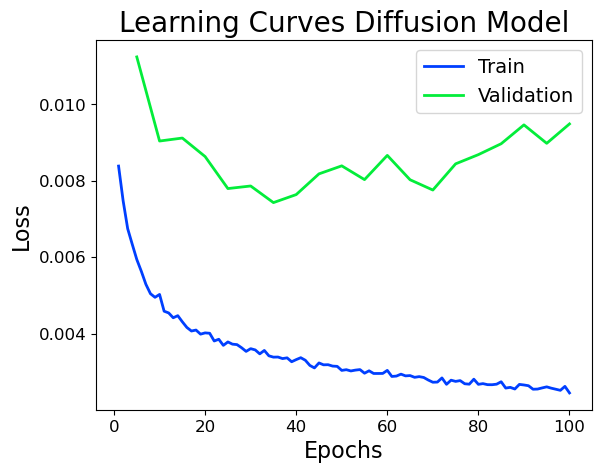

In [31]:

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        indexes = list(torch.randperm(total_train_slices.shape[0]))  # shuffle training data new
        data_train = total_train_slices[indexes]  # shuffle the training data
        labels_train = total_train_labels[indexes]
        subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))
        subset_2D_val = zip(total_val_slices.split(batch_size), total_val_labels.split(1))  #
        progress_bar = tqdm(enumerate(subset_2D), total=len(indexes) / batch_size)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, (a, b) in progress_bar:
            images = a.to(device)
            seg = b.to(device)  #this is the ground truth segmentation
            optimizer.zero_grad(set_to_none=True)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random time step t
            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(seg).to(device)
                noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)  #we only add noise to the segmentation mask
                combined=torch.cat((images,noisy_seg), dim=1)                               #we concatenate the brain MR image with the noisy segmenatation mask, to condition the generation process
                prediction = model(x=combined, timesteps=timesteps)
                # Get model prediction 
                loss = F.mse_loss(prediction.float(), noise.float())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()
            progress_bar.set_postfix(
                {
                    "loss": epoch_loss / (step + 1),
                }
            )
        epoch_loss_list.append(epoch_loss / (step + 1))
        if (epoch) % val_interval == 0:
            model.eval()
            val_epoch_loss = 0
            progress_bar_val = tqdm(enumerate(subset_2D_val))
            progress_bar.set_description(f"Epoch {epoch}")
            for step, (a, b) in progress_bar_val:
                images = a.to(device)
                seg = b.to(device)
                timesteps = torch.randint(0, 1000, (len(images),)).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(seg).to(device)
                        noisy_seg = scheduler.add_noise(original_samples=seg, noise=noise, timesteps=timesteps)
                        combined=torch.cat((images,noisy_seg), dim=1)
                        prediction = model(x=combined, timesteps=timesteps)
                        val_loss = F.mse_loss(prediction.float(), noise.float())
                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix(
                    {
                        "val_loss": val_epoch_loss / (step + 1),
                    }
                )
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))
total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")
plt.style.use("seaborn-bright")
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()


# Sampling of a new segmentation Mask for an input image of the validation set<br>

Starting from random noise, we want to generate a segmentation mask for a brain MR image of our validation set.\
Due to the stochastic generation process, we can sample an ensemble of n different segmentation masks per MR image.\
First, we pick an image of our validation set, and check the ground truth segmentation mask.

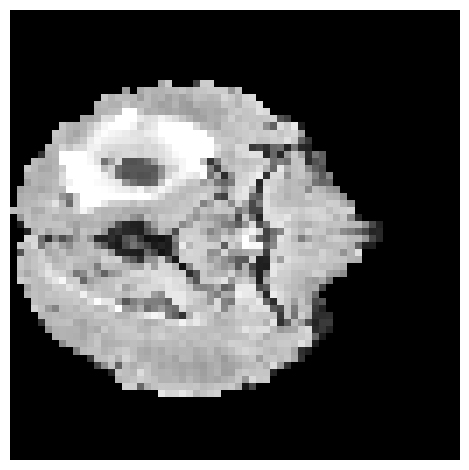

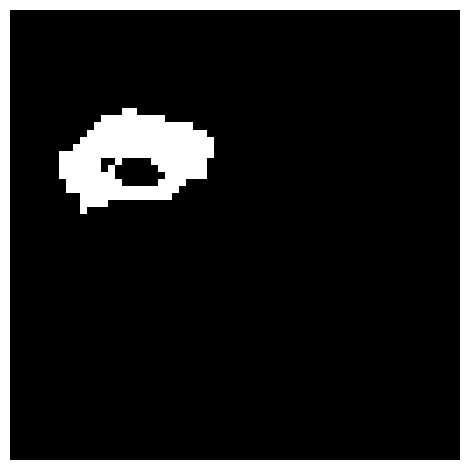

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (op):

In [47]:
inputimg = total_val_slices[100][0,...]  # Pick an input slice of the validation set to be segmented  
inputlabel= total_val_labels[100][0,...]     # Check out the ground truth label mask
plt.figure("input"+str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure("input"+str(inputlabel))
plt.imshow(inputlabel, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


model.eval()



Then we set the number of samples in the ensemble n.

In [64]:
n=5
input_img = inputimg[None, None, ...].to(device)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.79it/s]


chain torch.Size([1, 1, 64, 704])


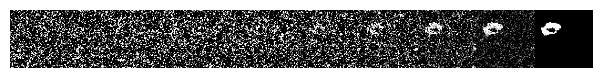

len ensd 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.32it/s]


chain torch.Size([1, 1, 64, 704])


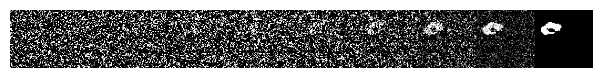

len ensd 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.38it/s]


chain torch.Size([1, 1, 64, 704])


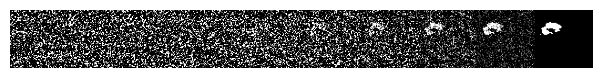

len ensd 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.13it/s]


chain torch.Size([1, 1, 64, 704])


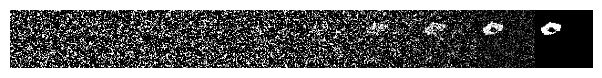

len ensd 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.72it/s]

chain torch.Size([1, 1, 64, 704])


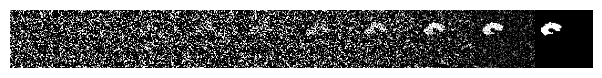

len ensd 5


In [69]:
Ensemble=[]
for k in range(5):
    noise = torch.randn_like(input_img).to(device) 
    current_img=noise                               #for the segmentation mask, we start from random noise.
    combined=torch.cat((input_img,noise), dim=1)    #We concatenate the input brain MR image to add anatomical information.

    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    chain=torch.zeros(current_img.shape)
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(model_output, t, current_img)  #this is the prediction x_t at the time step t 
                if t%100==0:
                    chain=torch.cat((chain, current_img.cpu()), dim=-1)
                combined=torch.cat((input_img,current_img), dim=1)   #in every step during the denoising process, the brain MR image is concatenated to add anatomical information

    print('chain', chain.shape)
    plt.style.use("default")
    plt.imshow(chain[0,0,...,64:].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    Ensemble.append(current_img)
    print('len ensd', len(Ensemble))
    prediction=torch.zeros(current_img.shape)  #this is the output of the diffusion model after T=1000 denoising steps.
    prediction[current_img>0.5]=1   #a binary mask is obtained via thresholding





## Segmentation prediction
The predicted segmentation mask is obtained from the output of the diffusion model by thresholding.\
We compute the Dice score for all predicted segmentations of the ensemble, as well as the pixel-wise mean and the variance map over the ensemble.\
We see that taking the mean over n=5 samples improves the segmentation performance.\
The variance maps highlights pixels where the model is unsure about it's own prediction



In [88]:
def dice_coeff(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() / im_sum)

Dice score of sample0 0.9272237196765498
Dice score of sample1 0.9393139841688655
Dice score of sample2 0.9205479452054794
Dice score of sample3 0.918918918918919
Dice score of sample4 0.9222520107238605
Dice score on the mean map 0.9436997319034852


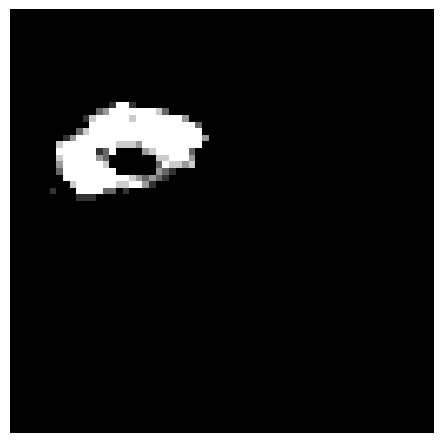

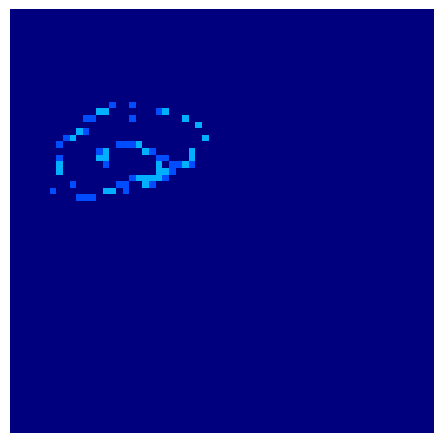

In [87]:
for i in range(len(Ensemble)):
    
    prediction=torch.where(Ensemble[i] > 0.5, 1, 0).float()   #a binary mask is obtained via thresholding
    score=dice_coeff(prediction[0, 0].cpu(), inputlabel.cpu()) #we compute the dice scores for all samples separately
    print('Dice score of sample' + str(i), score)


E=torch.where(torch.cat(Ensemble) > 0.5, 1, 0).float()
var=torch.var(E, dim=0)   #pixel-wise variance map over the ensemble
mean=torch.mean(E, dim=0)  #pixel-wise mean map over the ensemble
mean_prediction=torch.where(mean > 0.5, 1, 0).float()

score=dice_coeff(mean_prediction[0, ...].cpu(), inputlabel.cpu()) #Here we predict the Dice score for the mean map
print('Dice score on the mean map', score)

plt.style.use("default")
plt.imshow(mean[0,...].cpu(), vmin=0, vmax=1, cmap="gray")  #We plot the mean map
plt.tight_layout()
plt.axis("off")
plt.show()
plt.style.use("default")
plt.imshow(var[0,...].cpu(), vmin=0, vmax=1, cmap="jet")  #We plot the variance map
plt.tight_layout()
plt.axis("off")
plt.show()

